<h1>1. Business Understanding:</h1>
<h3>Business Goal:</h3> The objective of this project is to develop a predictive model that forecasts future house prices in a specific city using historical data of the S&P 500 stock prices and the corresponding historical house prices in that city. This model aims to provide valuable insights for real estate investors, financial analysts, and homebuyers who are seeking to understand the relationship between stock market performance and housing market trends.

<h3>Problem Context:</h3> The housing market is influenced by a variety of factors, one of the most prominent being the broader economic environment, which is often reflected in stock market performance. In this project, I am focusing on the S&P 500 index, a key benchmark for the overall performance of the U.S. stock market, and using it as a potential predictor for future house prices.

The dataset will include historical data from the year 2000 onwards, capturing fluctuations in both the stock market and housing prices in the target city. By analyzing the relationships between these variables, the goal is to build a model that can predict future house prices, helping stakeholders in the real estate market make informed decisions.

<h3>Objectives:</h3>

Use historical S&P 500 stock prices and house prices in a city to build a predictive model for future house prices.
Identify the correlation between stock market trends (S&P 500 index) and real estate market trends (house prices).
Provide forecasts of house prices for a specific city based on the data from 2000 onwards.
<h3>Key Questions:</h3>

What is the most effective model for predicting future house prices using the stock market as a predictor?
Can the model help in forecasting potential real estate market conditions based on stock market trends?
<h3>Success Criteria:</h3>

The accuracy of the model in predicting future house prices, which can be measured using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), or R².
The ability of the model to generalize across different periods, ensuring its robustness in forecasting.
The interpretability of the model's features, specifically how stock market data influences housing price predictions.



<h1>2. Data Understanding and Data Preparation</h1>

In [348]:
import pandas as pd

In [349]:
#Read the Zillow house price development data into a DataFrame called df
df = pd.read_csv('https://github.com/JaFaSch/house-market-prediction/raw/main/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [350]:
#Read S&P 500 historical data into a DataFrame called df_SP
df_SP = pd.read_csv('https://github.com/JaFaSch/house-market-prediction/raw/main/S%26P%20500%20Historical%20Data.csv')

In [351]:
#Remove unnecessary columns from the Zillow data
columns_to_drop = ['RegionID', 'SizeRank', 'RegionType', 'StateName']
df = df.drop(columns=columns_to_drop)

In [352]:
#Remove unnecessary columns from the S&P 500 data
df_SP.drop(columns=['Open', 'High', 'Low', 'Vol.','Change %'], inplace=True)

In [353]:
#Reverse the order of rows in df_SP (making the oldest date first) and reset the index
df_SP = df_SP.iloc[::-1].reset_index(drop=True)

In [354]:
# Extract the first column of df
first_column = df.iloc[:, 0]
# Extract the rest of the columns from df for interpolation
remaining_columns = df.iloc[:, 1:]
# Convert object-type columns to more specific types like numeric if possible
remaining_columns = remaining_columns.infer_objects()
# Fill missing values in remaining_columns using linear interpolation
remaining_columns_interpolated = remaining_columns.interpolate(method='linear', limit_direction='both')
# Combine the first column with the interpolated data
df = pd.concat([first_column, remaining_columns_interpolated], axis=1)

In [355]:
# Ensure no NaN values are present in the DataFrame
nan_counts_per_column = df.isnull().sum()
print("NaN values per column:")
print(nan_counts_per_column)
total_nan_count = nan_counts_per_column.sum()
print("\nTotal number of NaN values in the DataFrame:")
print(total_nan_count)

NaN values per column:
RegionName    0
2000-01-31    0
2000-02-29    0
2000-03-31    0
2000-04-30    0
             ..
2024-05-31    0
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
Length: 298, dtype: int64

Total number of NaN values in the DataFrame:
0


In [356]:
# Set the 'RegionName' column as the index for the Zillow DataFrame
df.set_index('RegionName', inplace=True)
# Transpose df so that the regions are now the columns and the dates are the rows
df_final= df.T
# Drop the last row in the transposed DataFrame
df_final = df_final.drop(df_final.index[-1])
# Convert the index of df_final to datetime format
df_final.index = pd.to_datetime(df_final.index)
# Adjust the frequency of the DataFrame to monthly
df_final = df_final.asfreq('M')

In [357]:
# Clean the 'Price' column by removing commas, converting to float
df_SP['Price'] = df_SP['Price'].str.replace(',', '').astype(float)

In [358]:
df_final.index = pd.to_datetime(df_final.index)
# Convert the 'Date' column in df_SP to datetime format
df_SP['Date'] = pd.to_datetime(df_SP['Date']) 
# Set 'Date' as the index for df_SP
df_SP.set_index('Date', inplace=True) 

# Compare the number of rows between df_SP and df_final to ensure alignment
if len(df_SP) != len(df_final):
    print("Warning: df_SP and df_final do not have the same number of rows.")
else:
    print("df_SP and df_final have the same number of rows.")
    # Add the 'Price' column from df_SP into df_final as the first column
    df_final.insert(0, 'Price', df_SP['Price'].values)


df_SP and df_final have the same number of rows.


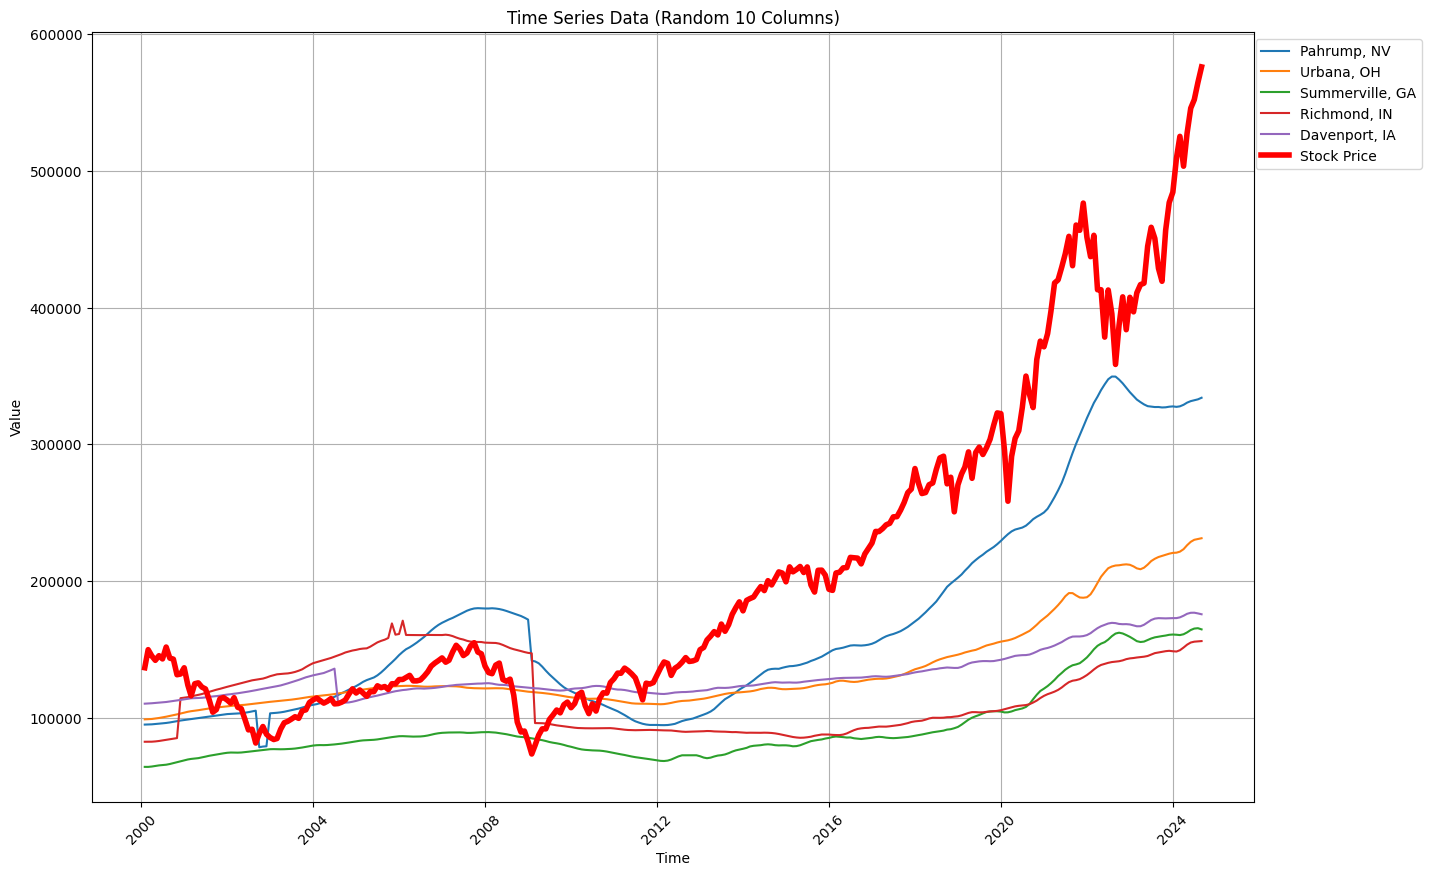

In [359]:
import matplotlib.pyplot as plt
import random
# Select 5 random columns (ensuring 'Price' is included) and plots their time series against the index
random_columns = random.sample(list(df_final.columns), 5)
if 'Price' not in random_columns:
    random_columns.append('Price')
plt.figure(figsize=(15, 10))
for column in random_columns:
    if column == 'Price':
        plt.plot(df_final.index, df_final['Price']*100, label=f'Stock Price', color = 'red', linewidth=4)
    else:
        plt.plot(df_final.index, df_final[column], label=column)


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data (Random 10 Columns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.show()

In [360]:
import ipywidgets as widgets
from IPython.display import display
# Provide a user-friendly dropdown to select a city column from the dataset for analysis
column_names = sorted(df_final.columns[1:].tolist())
import json
with open('column_names.json', 'w') as f:
    json.dump(column_names, f)
dropdown = widgets.Dropdown(
    options=column_names,
    description='Columns:',
    disabled=False,
)

display(dropdown)

Dropdown(description='Columns:', options=('Aberdeen, SD', 'Aberdeen, WA', 'Abilene, TX', 'Ada, OK', 'Adrian, M…

In [361]:
city = dropdown.value

In [362]:
# Check if the selected city is valid; if not, defaults to 'United States'
if city in df_final.columns:
    print(f"'{city}' is a column name.")
    state_data = df_final[city]
else:
    print(f"'{city}' is not a column name.")
    city = 'United States'
    state_data = df_final['city']

'Aberdeen, SD' is a column name.


<h1> 3. Modeling</h1>

In [363]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

<h2> 3.1 ARIMAX</h2>

In [364]:
# Function to make the time series stationary
def make_stationary(series):
    while True:
        result = adfuller(series.dropna())
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"   {key}: {value}")

        if result[1] > 0.05:
            print("The series is non-stationary. Differencing the series.")
            series = series.diff().dropna()
        else:
            print("The series is stationary.")
            break
    return series


In [365]:
df_final['stationary_city'] = make_stationary(df_final[city])
stationary_city = 'stationary_city'


ADF Statistic: 0.7816670678879905
p-value: 0.9913344020691919
Critical Values:
   1%: -3.452713099849546
   5%: -2.871387839457783
   10%: -2.5720171933352485
The series is non-stationary. Differencing the series.
ADF Statistic: -16.62319918462823
p-value: 1.6909827817165258e-29
Critical Values:
   1%: -3.452789844280995
   5%: -2.871421512222641
   10%: -2.5720351510944512
The series is stationary.


In [366]:
df_final['stationary_price'] = make_stationary(df_final['Price'])
stationary_price = 'stationary_price'


ADF Statistic: 2.2333707040560076
p-value: 0.9989088586280803
Critical Values:
   1%: -3.4540076534999957
   5%: -2.8719557347997178
   10%: -2.5723200648758366
The series is non-stationary. Differencing the series.
ADF Statistic: -3.2914457605261287
p-value: 0.015265206297084033
Critical Values:
   1%: -3.4540076534999957
   5%: -2.8719557347997178
   10%: -2.5723200648758366
The series is stationary.


In [367]:
df_final.dropna(subset=['stationary_city'], inplace=True)
df_final.dropna(subset=['stationary_price'], inplace=True)

In [368]:
# Define a function to predict house prices using lagged features and ARIMA
def predict_houseprice(lag_SP, lag_house, stationary_city, forecast_periods=6):
    # Create lagged versions of house price and S&P 500 index columns based on the provided lag values
    df_final['HousePrice_Lag1'] = df_final[stationary_city].shift(lag_house)
    df_final['SP500_Lag1'] = df_final[stationary_price].shift(lag_SP)
    df_final.dropna(inplace=True)
    # Move the lagged columns (HousePrice_Lag1 and SP500_Lag1) to specific positions for better organization
    df_final.insert(2, 'HousePrice_Lag1', df_final.pop('HousePrice_Lag1'))
    df_final.insert(3, 'SP500_Lag1', df_final.pop('SP500_Lag1'))
    # Normalize lagged features using StandardScaler to ensure all inputs have a mean of 0 and a standard deviation of 1
    scaler = StandardScaler()
    df_final[['HousePrice_Lag1', 'SP500_Lag1']] = scaler.fit_transform(df_final[['HousePrice_Lag1', 'SP500_Lag1']])
    # Split the data into training (80%) and testing (20%) sets for features (SP500_Lag1) and target (city).
    train_size = int(len(df_final) * 0.8)
    X_train, X_test = df_final[['SP500_Lag1']][:train_size], df_final[['SP500_Lag1']][train_size:]
    y_train, y_test = df_final[stationary_city][:train_size], df_final[stationary_city][train_size:]
    # Training ARIMA Models
    best_mae = np.inf
    best_order = None
    best_model = None
    for p in range(0, 2):  # Try p values from 0 to 2
            for q in range(0, 2):  # Try q values from 0 to 2
                d = 0
                try:
                    model = ARIMA(y_train, order=(p, d, q), exog=X_train)
                    model_fit = model.fit()
                    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
                    
                    mae = mean_absolute_error(y_test, y_pred)
                    if mae < best_mae:
                        best_mae = mae
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    continue
    # Use the last value of X_test to predict future values for the specified forecast_periods
    future_exog = np.tile(X_test.iloc[-1].values, (forecast_periods, 1))  # Use the last SP500_Lag1 value for future
    future_pred = best_model.forecast(steps=forecast_periods, exog=future_exog)

    # Combine historical test predictions and future predictions
    y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
    y_pred_combined = np.concatenate([y_pred, future_pred])

    # MAE and MSE for test set
    mae = mean_absolute_error(y_test, y_pred[:len(y_test)])
    mse = mean_squared_error(y_test, y_pred[:len(y_test)])
    return y_test, y_pred_combined, train_size, df_final.index[train_size:], future_pred, best_model, X_test, best_order

In [369]:
import warnings

# Suppress UserWarning
warnings.filterwarnings("ignore", category=UserWarning)
best_mae = float('inf')
best_mse = float('inf')
best_lag_SP = None
best_lag_house = None

# Test various combinations of lag values to determine the best-performing configuration.
for lag_SP in range(6, 12):
    for lag_house in range(1, 4):
        y_test, y_pred, train_size, pred_index, future_pred, best_model, X_test, best_order = predict_houseprice(lag_SP, lag_house, stationary_city)
        y_pred_combined = np.concatenate([y_pred, future_pred])
        mae = mean_absolute_error(y_test, y_pred[:len(y_test)])
        mse = mean_squared_error(y_test, y_pred[:len(y_test)])
        print(f"lag_SP: {lag_SP}, lag_house: {lag_house}, MAE: {mae}, MSE: {mse}")
        
        # Update the best MAE and the corresponding lag values if the current MAE is better
        if mae < best_mae:
            best_mae = mae
            best_lag_SP = lag_SP
            best_lag_house = lag_house




lag_SP: 6, lag_house: 1, MAE: 1110.1075796492448, MSE: 1992591.509771399
lag_SP: 6, lag_house: 2, MAE: 1083.7009131279437, MSE: 1924591.2048257927
lag_SP: 6, lag_house: 3, MAE: 1098.9804686170608, MSE: 1986567.2267020917
lag_SP: 7, lag_house: 1, MAE: 895.1569233828596, MSE: 1183828.4113588012
lag_SP: 7, lag_house: 2, MAE: 908.0161783203744, MSE: 1203676.4685143973
lag_SP: 7, lag_house: 3, MAE: 922.1596105713155, MSE: 1222338.840953491
lag_SP: 8, lag_house: 1, MAE: 940.7052282078481, MSE: 1254663.224475513
lag_SP: 8, lag_house: 2, MAE: 935.9677843563168, MSE: 1251006.2322974436
lag_SP: 8, lag_house: 3, MAE: 926.4609836857263, MSE: 1226242.5495039094
lag_SP: 9, lag_house: 1, MAE: 1071.102706197568, MSE: 1799900.1526341203
lag_SP: 9, lag_house: 2, MAE: 983.9892278855518, MSE: 1525241.698209105
lag_SP: 9, lag_house: 3, MAE: 937.3969696501622, MSE: 1403199.5396101582
lag_SP: 10, lag_house: 1, MAE: 801.6840381248993, MSE: 1009105.604842105
lag_SP: 10, lag_house: 2, MAE: 771.297376300053, MSE

In [370]:
# Print the best MAE and the corresponding lag values
print(f"Best MAE: {best_mae} with lag_SP: {best_lag_SP} and lag_house: {best_lag_house}")
print(f"Best MSE: {best_mse} with lag_SP: {best_lag_SP} and lag_house: {best_lag_house}")

Best MAE: 649.3136930494348 with lag_SP: 11 and lag_house: 3
Best MSE: inf with lag_SP: 11 and lag_house: 3


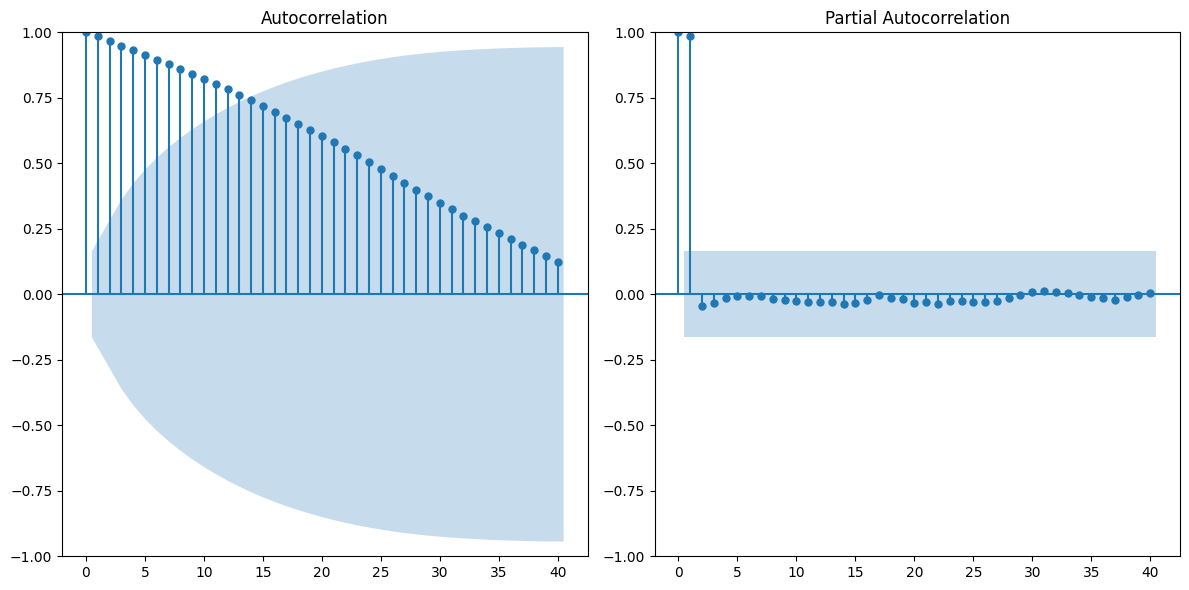

In [371]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the selected city
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_final[city].dropna(), lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(df_final[city].dropna(), lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()


In [372]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

<h2> 3.2 Regressor</h2>

In [373]:
# The regressors dictionary defines three regression models 
# (RandomForest, GradientBoosting, LinearRegression) with their respective hyperparameters for tuning
regressors = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
        },
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 10],
        },
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {},  
    },
}


In [374]:
# Prepare data for regressors
X = df_final[['SP500_Lag1']].iloc[:train_size]  # Features (up to train size)
y = df_final[city].iloc[:train_size]  # Target (up to train size)

In [375]:
# Initialize an empty dictionary to store the results of GridSearchCV for each regressor, 
# including the best model and its corresponding Mean Absolute Error (MAE)
grid_search_results = {}

In [376]:

# Perform GridSearchCV for each regressor, optimize MAE, and store the best model and score.
for regressor_name, regressor in regressors.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', regressor['model']),
    ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid=regressor['params'],
        scoring='neg_mean_absolute_error',
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,
        verbose=2,
    )
    print(f"Running GridSearchCV for {regressor_name}...")
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    best_score = -grid_search.best_score_  # Convert back to positive MAE
    grid_search_results[regressor_name] = {
        'model': best_model,
        'MAE': best_score,
    }
    

Running GridSearchCV for RandomForest...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......model__max_depth=None, model__n_estimators=50; total time=   0.0s
[CV] END ......model__max_depth=None, model__n_estimators=50; total time=   0.0s
[CV] END ......model__max_depth=None, model__n_estimators=50; total time=   0.0s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=   0.0s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=   0.0s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=   0.0s
[CV] END .....model__max_depth=None, model__n_estimators=200; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.0s
[CV] END

In [377]:
print("\nGrid Search Results:")
for model_name, result in grid_search_results.items():
    print(f"{model_name}: Best MAE = {result['MAE']:.4f}")


Grid Search Results:
RandomForest: Best MAE = 20017.9887
GradientBoosting: Best MAE = 19465.7300
LinearRegression: Best MAE = 20496.8708


<h1> 4. Evaluation</h1>

In [378]:
# Compare best regressor with the best ARIMA model
best_regressor_name = min(grid_search_results, key=lambda name: grid_search_results[name]['MAE'])
best_regressor_mae = grid_search_results[best_regressor_name]['MAE']

In [379]:
# Print the best method and its corresponding MAE
print("\nComparison:")
print(f"Best ARIMA MAE: {best_mae}")
print(f"Best Regressor ({best_regressor_name}) MAE: {best_regressor_mae}")

if best_regressor_mae < best_mae:
    print(f"The best regressor ({best_regressor_name}) outperforms the ARIMA model.")
else:
    print("The ARIMA model outperforms all tested regressors.")



Comparison:
Best ARIMA MAE: 649.3136930494348
Best Regressor (GradientBoosting) MAE: 19465.73003001299
The ARIMA model outperforms all tested regressors.


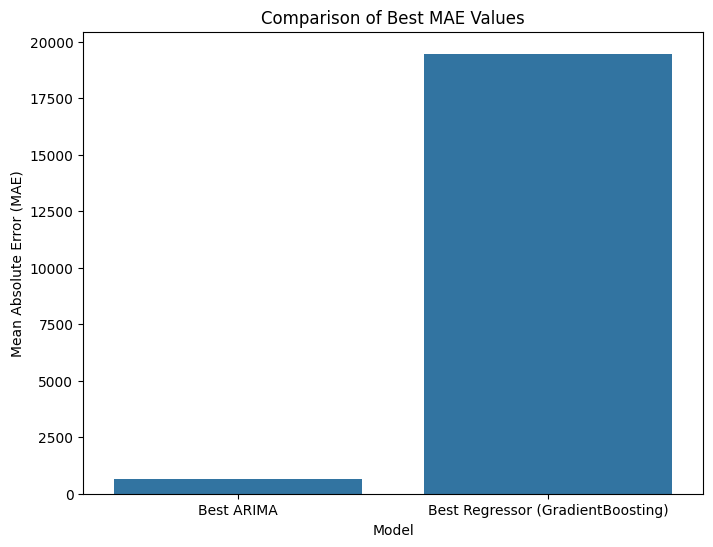

In [380]:
# Plot comparison of best MAE values
import seaborn as sns
data = {
    'Model': ['Best ARIMA', f'Best Regressor ({best_regressor_name})'],
    'MAE': [best_mae, best_regressor_mae]
}

df_mae = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=df_mae)
plt.title('Comparison of Best MAE Values')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.show()

<h1>6. Deployment</h1>

In [381]:
# Initialize a DataFrame with actual and predicted house prices, setting predictions as NaN initially
predicted_df = pd.DataFrame({
    'Actual': df_final[stationary_city],
    'Predicted': np.nan  # Start with NaN for the predictions
}, index=df_final.index)

# Fill the 'Predicted' column with predictions starting from the training size
predicted_df.loc[pred_index, 'Predicted'] = y_pred[:len(pred_index)]  # Use pred_index here and limit y_pred

# Include future predictions as well
if future_pred is not None:
    # Calculate the start index for future predictions
    future_start_index = pred_index[-1] + pd.DateOffset(months=1)  # Next month after last prediction
    predicted_df.loc[future_start_index:future_start_index + pd.DateOffset(months=len(future_pred)-1), 'Predicted'] = future_pred


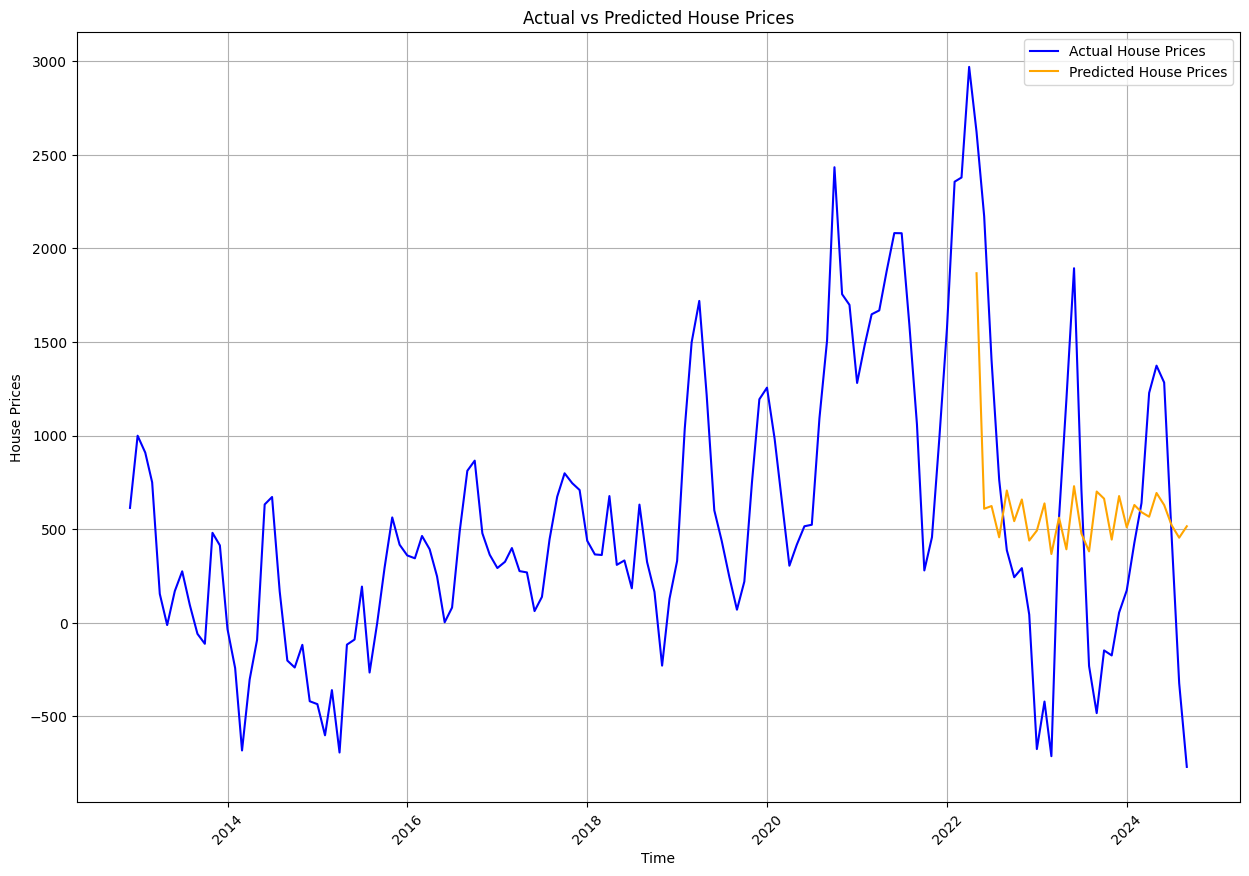

In [382]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predicted_df is your DataFrame with actual and predicted values

# Create the Seaborn plot
plt.figure(figsize=(15, 10))
sns.lineplot(data=predicted_df, x=predicted_df.index, y='Actual', label='Actual House Prices', color='blue')
sns.lineplot(data=predicted_df, x=predicted_df.index, y='Predicted', label='Predicted House Prices', color='orange')

# Set plot title and labels
plt.xlabel('Time')
plt.ylabel('House Prices')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.show()
